In [1]:
import os
import anndata as ad
import umap
import scipy as sip
from scipy import sparse
from sklearn import preprocessing
import scanpy as scp
import pickle
import pandas as pd
import numpy as np
import igraph as ig
import seaborn as sb
import snf
import sklearn as skl
from sklearn import cluster
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import v_measure_score
from snf import compute, metrics
import matplotlib.pyplot as plt
from PyComplexHeatmap import *
from collections import Counter
import math
import itertools

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-usin

In [2]:
data = os.path.abspath(os.path.join(os.getcwd(),"../data"))

input = os.path.join(data, "input")
output = os.path.join(data, "output")

original = os.path.join(input, "original")
complementary = os.path.join(input, "complementary")

pb = os.path.join(output, "pb")
shared = os.path.join(output, "shared")


level1 = os.path.join(output, "level1")
level2 = os.path.join(output, "level2")
level4 = os.path.join(output, "level4")

level3_concat = os.path.join(output, "level3_concat")
level3_snf = os.path.join(output, "level3_snf")

In [73]:
with open(os.path.join(complementary, "shared_patients_across_level1_networks_74.pickle"), "rb") as f:
    patients_74 = pickle.load(f) 
with open(os.path.join(level1, "module_data.pickle"), "rb") as f:
    module_data = pickle.load(f) 
with open(os.path.join(level1, "noise_graphs_with_74_nodes.pickle"), "rb") as f:
    noise_74 = pickle.load(f) 

with open(os.path.join(complementary, "noise_name_to_id.pickle"), "rb") as f:
    noise_name_to_id = pickle.load(f) 
with open(os.path.join(complementary, "noise_id_to_name.pickle"), "rb") as f:
    noise_id_to_name = pickle.load(f) 
with open(os.path.join(complementary, "id_to_name.pickle"), "rb") as f:
    id_to_name = pickle.load(f) 
with open(os.path.join(complementary, "name_to_id.pickle"), "rb") as f:
    name_to_id = pickle.load(f) 
with open(os.path.join(complementary, "id_to_modality.pickle"), "rb") as f:
    id_to_modality = pickle.load(f) 

with open(os.path.join(complementary, "module_name_to_id.pickle"), "rb") as f:
    module_name_to_id = pickle.load(f) 
with open(os.path.join(complementary, "id_to_module_name.pickle"), "rb") as f:
    id_to_module_name = pickle.load(f) 

with open(os.path.join(shared, 'shared_patient_75_to_all_diseases.pickle'), 'rb') as f:
    patient_to_disease_evolution = pickle.load(f)
with open(os.path.join(shared, 'patient_to_assigned_disease.pickle'), 'rb') as f:
    patient_to_disease = pickle.load(f)
with open(os.path.join(shared, 'patient_to_disease_group.pickle'), 'rb') as f:
    patient_to_disease_group = pickle.load(f)
with open(os.path.join(shared, 'disease_group_to_patient.pickle'), 'rb') as f:
    disease_group_to_patient = pickle.load(f)
with open(os.path.join(shared, 'assigned_disease_to_patient.pickle'), 'rb') as f:
    patient_to_disease = pickle.load(f)


In [4]:
with open(os.path.join(level1, "ad_graphs.pickle"), "rb") as f:
    level1_graphs = pickle.load(f) 
with open(os.path.join(level2, "ad_graphs.pickle"), "rb") as f:
    level2_graphs = pickle.load(f) 
with open(os.path.join(level3_concat, "ad_graphs.pickle"), "rb") as f:
    level3_concat_graphs = pickle.load(f) 
with open(os.path.join(level4, "ad_graphs.pickle"), "rb") as f:
    level4_graphs = pickle.load(f) 

In [5]:
graphs_74 = level1_graphs

In [6]:
diseases = list(graphs_74["G0"].obs.Disease.unique())
disease_groups = list(graphs_74["G0"].obs.DiseaseGroup.unique())

In [7]:
# For every modality, extract the set of graphs belonging to it
citeRNA_g_with_74 = {}
bulkRNA_g_with_74 = {}
luminex_g_with_74 = {}
cytof_g_with_74 = {}
adt_g_with_74 = {}
facs_g_with_74 = {}
for id, g in graphs_74.items():
    modality = g.uns["modality"]
    if modality == "citeRNA":
        citeRNA_g_with_74[id] = g
    elif modality == "bulkRNA":
        bulkRNA_g_with_74[id] = g
    elif modality == "cytof":
        cytof_g_with_74[id] = g
    elif modality == "luminex":
        luminex_g_with_74[id] = g
    elif modality == "facs":
        facs_g_with_74[id] = g
    elif modality == "adt":
        adt_g_with_74[id] = g

In [9]:
ground_truth_dg = {}
ground_truth_d = {}
for p in graphs_74["G0"].obs_names:
    dg = graphs_74["G0"][p].obs.DiseaseGroup[0]
    d = graphs_74["G0"][p].obs.Disease[0]

    if dg == "Healthy":
        ground_truth_dg[p] = 0
    elif dg == "Sepsis":
        ground_truth_dg[p] = 1
    elif dg == "COVID":
        ground_truth_dg[p] = 2

    if d == "COVID_HCW_MILD":
        ground_truth_d[p] = 0
    elif d == "HV":
        ground_truth_d[p] = 1
    elif d == "Sepsis":
        ground_truth_d[p] = 2
    elif d == "COVID_MILD":
        ground_truth_d[p] = 3
    elif d == "COVID_SEV":
        ground_truth_d[p] = 4
    elif d == "COVID_CRIT":
        ground_truth_d[p] = 5

In [10]:
interesting_patients = [
"S00027-Ja003",
"S00033-Ja003",
"S00033-Ja005",
"S00068-Ja005",
"S00095-Ja005",
"S00065-Ja003",
"S00005-Ja005",
"S00040-Ja005",
"S00119-Ja003",
"S00020-Ja003"]
interesting_patients = set([p.split("-")[0] for p in interesting_patients]) # Extract ids, remove duplicates
interesting_patients = list(set(patients_74).intersection(interesting_patients))


healthy_patients = [p for p in list(graphs_74["G0"].obs_names) if graphs_74["G0"][p].obs.Disease[0] == "HV"]


palette = ig.RainbowPalette(n=7)
disease_color_map = {diseases[i]:palette[i] for i in range(6)}
palette = ig.RainbowPalette(n=3)
disease_group_color_map = {disease_groups[i]:palette[i] for i in range(3)}

In [11]:
panelize_reward_d = []
panelize_reward_dg = []

for i in patients_74:
    panelize_reward_d_ij = []
    panelize_reward_dg_ij = []

    d1 = graphs_74["G0"][i].obs.Disease[0]
    dg1 = graphs_74["G0"][i].obs.DiseaseGroup[0]

    for j in patients_74:
        d2 = graphs_74["G0"][j].obs.Disease[0]
        dg2 = graphs_74["G0"][j].obs.DiseaseGroup[0]

        if d1 == d2:
            panelize_reward_d_ij.append(1)
        else:
            panelize_reward_d_ij.append(-1)
        """elif dg1 == dg2:
            p_d_ij.append(0.5)
        elif d1 == "HV" or d2 == "HV":
            p_d_ij.append(-1)
        else:
            p_d_ij.append(-0.5)"""

        if dg1 == dg2:
            panelize_reward_dg_ij.append(1)
        elif dg1 == "Healthy" or dg2 == "Healthy":
            panelize_reward_dg_ij.append(-2)
        else:
            panelize_reward_dg_ij.append(-1)

    panelize_reward_d.append(panelize_reward_d_ij)
    panelize_reward_dg.append(panelize_reward_dg_ij)


for i in range(len(panelize_reward_dg)):
    panelize_reward_d[i][i] = 0
    panelize_reward_dg[i][i] = 0

panelize_reward_d = np.array(panelize_reward_d, dtype="float64")
panelize_reward_dg = np.array(panelize_reward_dg, dtype="float64")

In [12]:
optimal_graph = []
for i, dg1 in enumerate(list(graphs_74["G0"].obs.DiseaseGroup)):
    neighbors_of_i = []
    for j, dg2 in enumerate(list(graphs_74["G0"].obs.DiseaseGroup)):
        if i == j or dg1 != dg2:
            neighbors_of_i.append(0)
        else:
            neighbors_of_i.append(1)
    optimal_graph.append(neighbors_of_i)
    
optimal_graph = np.array(optimal_graph, dtype = "float64")
print(optimal_graph)

optimal_rw_score = 74

[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


In [13]:
modality_frequency_weights = {"citeRNA": 1/209, "bulkRNA": 1/12, "adt": 1/11, "facs": 1, "luminex": 1, "cytof": 1/12 }
modality_frequency_weights  = {id: modality_frequency_weights[g.uns["modality"]] for id, g in graphs_74.items()}
weighted_avg_weights = {id: 1/len(graphs_74)  for id, g in graphs_74.items()}

## Functions

In [14]:
def make_transition_matrix(fused_network):
    tm = []
    for i, row in enumerate(fused_network):
        tm.append(row/ sum(row))
    return tm

def random_walker_objective(transition_matrix):
    d_score = (transition_matrix * panelize_reward_d).sum()
    dg_score = (transition_matrix * panelize_reward_dg).sum()
    #score = 0.5 * d_score + 0.5 * dg_score
    score =  dg_score
    return d_score, dg_score, score

def adjust_weights(psns, scale_weights = modality_frequency_weights):
    adjusted_weights = {}
    for id, psn in psns.items():
        adjusted_weights[id] = psn * modality_frequency_weights[id]
    return adjusted_weights

In [15]:
def knn(g, k, metric): # g is an AnnData Object
    scp.pp.neighbors(g, n_neighbors = k, use_rep='X', metric =  metric) 
    return np.array(sparse.csr_matrix.todense(g.obsp["connectivities"]), dtype = "float64") # Returns a matrix

def aff(g, metric, k, mu ): # g is a list of matrices 
    return compute.make_affinity(g, metric=metric, K=k, mu=mu, normalize = False)  # Returns a list of matrices

In [176]:
def label_dict(level, include_wa = False, include_unimodal_knn = False, include_unimodal_corr = False):
    labels = {}
    if level == "level1":
        psns = list(optimal_psns_level1.values())
        corrs = list(correlations_level1.values())
        affs = list(optimal_affs_level1.values())
        ids = list(optimal_affs_level1.keys())
        path = level1
    elif level == "level2": 
        psns = list(optimal_psns_level2.values())
        corrs = list(correlations_level2.values())
        affs = list(optimal_affs_level2.values())
        ids = list(optimal_affs_level2.keys())
        path = level2
    elif level == "level3_concat":
        psns = list(optimal_psns_level3_concat.values())
        corrs = list(correlations_level3_concat.values())
        affs = list(optimal_affs_level3_concat.values())
        ids = list(optimal_affs_level3_concat.keys())
        path = level3_concat
    elif level == "level3_snf":
        corrs = list(level_3_snf_corr.values())
        affs = list(level_3_snf_aff.values())
        ids = list(level_3_snf_aff.keys())
        path = level3_snf
    elif level == "level4":
        psns = list(optimal_psns_level4.values())
        corrs = list(correlations_level4.values())
        affs = list(optimal_affs_level4.values())
        ids = list(optimal_affs_level4.keys())
        path = level4
    ###########################################################
    fused_kernel = compute.snf(affs, K=best_kernel["k"], t = 40) 

    if np.isnan(fused_kernel).any():
        nan_locs = np.argwhere(np.isnan(fused_kernel))
        for loc in nan_locs:
            fused_kernel[loc[0], loc[1]] = 0
        print(np.isnan(fused_kernel).any() == False)

    first, second = compute.get_n_clusters(fused_kernel)
    labels_fused_kernel = cluster.spectral_clustering(fused_kernel, n_clusters=first, n_init = 40)
    labels["labels_fused_kernel"] = labels_fused_kernel
    ###########################################################
    fused_corrs = compute.snf(corrs, K=best_kernel["k"], t = 40) 
    
    if np.isnan(fused_corrs).any():
        nan_locs = np.argwhere(np.isnan(fused_corrs))
        for loc in nan_locs:
            fused_corrs[loc[0], loc[1]] = 0
        print(np.isnan(fused_corrs).any() == False)

    first, second = compute.get_n_clusters(fused_corrs)
    labels_fused_corrs = cluster.spectral_clustering(fused_corrs, n_clusters=first, n_init = 40)
    labels["labels_fused_corrs"] = labels_fused_corrs
    ###########################################################
    if include_wa:
        fused_knn = sum(psns)
        if np.isnan(fused_knn).any():
            nan_locs = np.argwhere(np.isnan(fused_knn))
            for loc in nan_locs:
                fused_knn[loc[0], loc[1]] = 0
            print(np.isnan(fused_knn).any() == False)

        ad_wa_knn =ad.AnnData(fused_knn)
        ad_wa_knn.obsp["connectivities"] = fused_knn
        scp.tl.leiden(ad_wa_knn, resolution=1, adjacency=fused_knn, directed=False, use_weights=True)
        labels_fused_knn = list(ad_wa_knn.obs.leiden)
        labels["labels_fused_knn"] = labels_fused_knn
    ###########################################################
    unimodal_kernel_labels = {}
    for i in range(len(ids)):
        name = ids[i] 
        psn = affs[i]

        if np.isnan(psn).any():
            nan_locs = np.argwhere(np.isnan(psn))
            for loc in nan_locs:
                psn[loc[0], loc[1]] = 0
            print(np.isnan(psn).any() == False)
    
        first, second = compute.get_n_clusters(psn)
        unimodal_kernel_labels[name] = cluster.spectral_clustering(psn, n_clusters=first, n_init = 40)
    
    labels["unimodal_kernel_labels"] = unimodal_kernel_labels
    ###########################################################
    if include_unimodal_corr:
        unimodal_corr_labels = {}
        for i in range(len(ids)):
            name = ids[i] 
            psn = corrs[i]

            if np.isnan(psn).any():
                nan_locs = np.argwhere(np.isnan(psn))
                for loc in nan_locs:
                    psn[loc[0], loc[1]] = 0
                print(np.isnan(psn).any() == False)

            if np.isinf(psn).any():
                nan_locs = np.argwhere(np.isinf(psn))
                for loc in nan_locs:
                    psn[loc[0], loc[1]] = 0
                print(np.isinf(psn).any() == False)
            
            first, second = compute.get_n_clusters(psn)
            unimodal_corr_labels[name] = cluster.spectral_clustering(psn, n_clusters=first, n_init = 40)
        
        labels["unimodal_corr_labels"] = unimodal_corr_labels
    ###########################################################
    if include_unimodal_knn:
        unimodal_knn_labels = {}
        for i in range(len(ids)):
            name = ids[i] 
            psn = psns[i]
    
            scp.pp.neighbors(psn, n_neighbors = best_knn["k"], use_rep='X')
            scp.tl.leiden(psn, resolution=1, directed=False, use_weights=True)
            unimodal_knn_labels[name] = list(psn.obs.leiden)

        labels["unimodal_knn_labels"] = unimodal_knn_labels


    with open(os.path.join(path, 'labels.pickle'), 'wb') as f:
        pickle.dump(labels, f)
    return labels

# Optimization

## Optimizing PSNs

In [16]:
setup_knn = {}
ks = [4,5,6,7]
metrics = ["cosine", "euclidean", "sqeuclidean", "correlation", "seuclidean", "minkowski", "mahalanobis", "chebyshev", "canberra"]

combinations = set(itertools.product(ks, metrics))

In [17]:
for i, combi in enumerate(combinations):
    print(str(i), "/", str(len(combinations)))
    try:
        k = combi[0]
        metric = combi[1]
        graphs = {}
        fused = None
        for id, g in graphs_74.items():
            weight = modality_frequency_weights[id]
            graphs[id] = knn(g, k, metric)
            

            if fused is None:
                fused = weight * graphs[id]
            else:
                fused = weight * graphs[id] + fused
            
       
        transition = make_transition_matrix(fused)
        score = random_walker_objective(transition)[2]
    
        print("success")
        setup_knn[score] = {"k":k, "metric": metric}

    except np.linalg.LinAlgError:
        print(i, "fail")
        continue
    except BaseException:
        print(i, "fail")
        continue

0 / 36


/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: 

success
1 / 36
success
2 / 36
success
3 / 36
success
4 / 36
success
5 / 36
success
6 / 36
success
7 / 36
7 fail
8 / 36
success
9 / 36
success
10 / 36
success
11 / 36
success
12 / 36
success
13 / 36


In [ ]:
# no self-loop remove, t = 40, grid search, update hpp

In [19]:
setup_knn = {k: v for k, v in sorted(setup_knn.items(), key=lambda item: item[0])} # sort according to scores
best_knn = setup_knn[list(setup_knn.keys())[-1]]
print(best_knn)

{'k': 4, 'metric': 'correlation'}


In [16]:
#best_knn = {'k': 4, 'metric': 'correlation'}

In [16]:
setup_kernel = {}
ks = [4,5,6,7,8]
metrics = ["cosine", "euclidean", "sqeuclidean", "correlation", "seuclidean", "minkowski", "mahalanobis", "chebyshev", "canberra"]
mus = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

combinations = set(itertools.product(ks, metrics, mus))

In [17]:
id_to_feature_matrices_level1 = {} # standard normalized
for id, g in graphs_74.items():
    id_to_feature_matrices_level1[id] = g.X.copy()

In [19]:
for i, combi in enumerate(combinations):
    print(str(i), "/", str(len(combinations)))
    try:
        k = combi[0]
        metric = combi[1]
        mu = combi[2] 
        
        graphs = aff(list(id_to_feature_matrices_fine.values()), metric, k, mu)
        fused = compute.snf(graphs, K=k, t = 40)

        transition = make_transition_matrix(fused)
        score = random_walker_objective(transition)[2]

        print("success")
        setup_kernel[score] = {"k":k, "metric": metric, "mu": mu}
        
    except ValueError:
        print(i, "fail")
        continue

0 / 315
success
1 / 315
1 fail
2 / 315


KeyboardInterrupt: 

In [24]:
setup_kernel = {k: v for k, v in sorted(setup_kernel.items(), key=lambda item: item[0])} # sort according to scores
best_kernel = setup_kernel[list(setup_kernel.keys())[-1]]
print(best_kernel)

{'k': 8, 'metric': 'sqeuclidean', 'mu': 0.3}


In [18]:
#best_kernel = {'k': 8, 'metric': 'sqeuclidean', 'mu': 0.3}

# Level1

In [19]:
graphs_74 = level1_graphs

In [20]:
with open(os.path.join(level1, "id_to_feature_matrices.pickle"), "wb") as f:
    pickle.dump(id_to_feature_matrices_level1, f) 

In [21]:
optimal_psns_level1 = {}
for id, g in graphs_74.items():
    graph = knn(g, best_knn["k"], best_knn["metric"])
    optimal_psns_level1[id] = graph

noise_psns = {}
for id, g in noise_74.items():
    graph = knn(g, best_knn["k"], best_knn["metric"])
    noise_psns[id] = graph

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: 

In [22]:
optimal_affs_level1 = {}
graphs = compute.make_affinity(list(id_to_feature_matrices_level1.values()), metric=best_kernel["metric"], K=best_kernel["k"], mu=best_kernel["mu"], normalize = False)
for i, id in enumerate(graphs_74.keys()):
    optimal_affs_level1[id] = graphs[i]

noise_affs = {}
graphs_noise = [g.X for g in noise_74.values()]
graphs_noise = compute.make_affinity(graphs_noise, metric=best_kernel["metric"], K=best_kernel["k"], mu=best_kernel["mu"], normalize = False)
for i, id in enumerate(noise_74.keys()):
    noise_affs[id] = graphs_noise[i]

In [23]:
correlations_level1 = {}
for id, ad_obj in graphs_74.items():
    correlations_level1[id] = ad_obj.to_df().T.corr().to_numpy()

noise_correlations = {}
for id, ad_obj in noise_74.items():
    noise_correlations[id] = ad_obj.to_df().T.corr().to_numpy()

In [24]:
for id in noise_affs.keys():
    np.random.shuffle(noise_affs[id])
    np.random.shuffle(noise_psns[id])

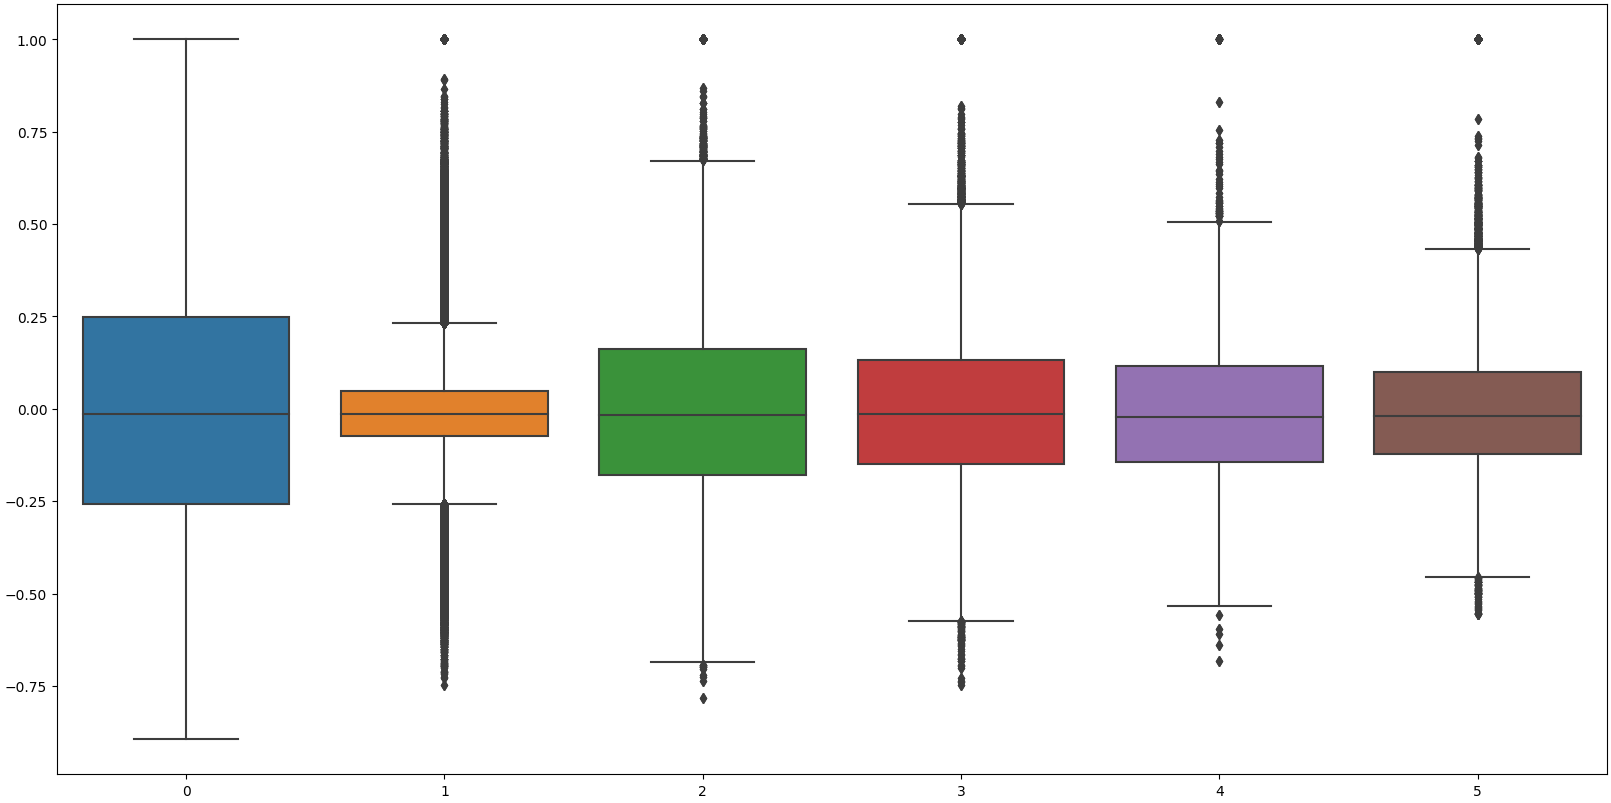

In [25]:
corr_info_per_modality = {m: [] for m in set(id_to_modality.values())}
for id, c in correlations_level1.items():
    m = id_to_modality[id]
    corr_info_per_modality[m] =corr_info_per_modality[m] + (list(c.flatten()))

fig, ax = plt.subplots(figsize=(20,10))
ax = sb.boxplot(list(corr_info_per_modality.values()), ax = ax )


correlations_original = correlations_level1.copy()
for id, c in correlations_level1.items():
    zeros = np.argwhere(c < 0)
    for z_loc in zeros:
        c[z_loc[0], z_loc[1]] = 0
    correlations_level1[id] = c

In [26]:
with open(os.path.join(level1, 'correlations.pickle'), 'wb') as f:
    pickle.dump(correlations_level1, f)
with open(os.path.join(level1, 'knn_PSNs.pickle'), 'wb') as f:
    pickle.dump(optimal_psns_level1, f)
with open(os.path.join(level1, 'kernel_PSNs.pickle'), 'wb') as f:
    pickle.dump(optimal_affs_level1, f)


with open(os.path.join(level1, 'noise_correlations.pickle'), 'wb') as f:
    pickle.dump(noise_correlations, f)
with open(os.path.join(level1, 'noise_knn_PSNs.pickle'), 'wb') as f:
    pickle.dump(noise_psns, f)
with open(os.path.join(level1, 'noise_kernel_PSNs.pickle'), 'wb') as f:
    pickle.dump(noise_affs, f)

In [31]:
"""with open(os.path.join(shared_74_fine, 'correlations.pickle'), 'rb') as f:
    correlations = pickle.load(f)
with open(os.path.join(shared_74_fine, 'knn_PSNs.pickle'), 'rb') as f:
    optimal_psns = pickle.load(f)
with open(os.path.join(shared_74_fine, 'kernel_PSNs.pickle'), 'rb') as f:
    optimal_affs = pickle.load(f)


with open(os.path.join(shared_74_fine, 'noise_correlations.pickle'), 'rb') as f:
    noise_correlations = pickle.load(f)
with open(os.path.join(shared_74_fine, 'noise_knn_PSNs.pickle'), 'rb') as f:
    noise_psns = pickle.load(f)
with open(os.path.join(shared_74_fine, 'noise_kernel_PSNs.pickle'), 'rb') as f:
    noise_affs = pickle.load(f)"""

In [32]:
"""for id, aff in optimal_affs.items():
    graphs_74[id].uns["PSN-kernel"] = aff

for id, psn in optimal_psns.items():
    graphs_74[id].uns["PSN-knn"] = psn"""

In [30]:
all_psns = list(noise_psns.values()) + list(optimal_psns_level1.values())
all_affs = list(noise_affs.values()) + list(optimal_affs_level1.values()) 
all_feature_matrices = [noise.X for noise in noise_74.values()] + list(id_to_feature_matrices_level1.values()) 
all_correlations = list(noise_correlations.values()) + list(correlations_level1.values())
all_names = list(noise_psns.keys()) + list(optimal_affs_level1.keys()) 

In [ ]:
all_dict = {"all_psns": all_psns, "all_affs": all_affs, "all_feature_matrices": all_feature_matrices,  "all_correlations": all_correlations, "all_names":all_names}

with open(os.path.join(level1, 'all_dict.pickle'), 'wb') as f:
    pickle.dump(all_dict, f)

## Labels
run <b>Finding the Weights for the Weighted Average</b> fusion first

In [164]:
label_dict("level1")

{'labels_fused_kernel': array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 3, 1, 0, 0, 0, 0, 0], dtype=int32),
 'labels_fused_corrs': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1], dtype=int32),
 'unimodal_kernel_labels': {'G0': array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 2, 2, 3, 3, 0, 3, 3, 3, 1,
         3, 1, 0, 0, 0, 3, 0, 3, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 3, 1, 0, 3, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0,
         0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
  'G1': array([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
         0, 0, 0, 1, 0, 0, 0, 1

### Kernel + SNF + SC

In [126]:
# No noise
fused = compute.snf(list(optimal_affs_level1.values()), K=best_kernel["k"], t = 40) 

first, second = compute.get_n_clusters(fused)
labels_sc_snf_kernel = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

"""ad_snf_kernel =ad.AnnData(fused)
ad_snf_kernel.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_kernel, resolution=0.25, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_kernel = list(ad_snf_kernel.obs.leiden)"""

'ad_snf_kernel =ad.AnnData(fused)\nad_snf_kernel.obsp["connectivities"] = fused\nscp.tl.leiden(ad_snf_kernel, resolution=0.25, adjacency=fused, directed=False, use_weights=True)\nlabels_leiden_snf_kernel = list(ad_snf_kernel.obs.leiden)'

In [127]:
# Only noise
fused = compute.snf(list(noise_affs.values()), K=best_kernel["k"], t = 40) 

first, second = compute.get_n_clusters(fused)
labels_sc_snf_kernel_noise = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

"""ad_snf_kernel =ad.AnnData(fused)
ad_snf_kernel.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_kernel, resolution=0.25, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_kernel_noise = list(ad_snf_kernel.obs.leiden)"""

'ad_snf_kernel =ad.AnnData(fused)\nad_snf_kernel.obsp["connectivities"] = fused\nscp.tl.leiden(ad_snf_kernel, resolution=0.25, adjacency=fused, directed=False, use_weights=True)\nlabels_leiden_snf_kernel_noise = list(ad_snf_kernel.obs.leiden)'

In [128]:
# Both noise and original graphs
fused = compute.snf(all_affs, K=best_kernel["k"], t = 40) 

first, second = compute.get_n_clusters(fused)
labels_sc_snf_kernel_all = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

"""ad_snf_kernel =ad.AnnData(fused)
ad_snf_kernel.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_kernel, resolution=0.25, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_kernel_all = list(ad_snf_kernel.obs.leiden)"""


'ad_snf_kernel =ad.AnnData(fused)\nad_snf_kernel.obsp["connectivities"] = fused\nscp.tl.leiden(ad_snf_kernel, resolution=0.25, adjacency=fused, directed=False, use_weights=True)\nlabels_leiden_snf_kernel_all = list(ad_snf_kernel.obs.leiden)'

In [129]:
# Single PSNs, Spectral Clustering
labels_kernel_psn_sc = {}

for i in range(len(all_names)):
    name = all_names[i] 
    psn = all_affs[i]
    
    first, second = compute.get_n_clusters(psn)
    labels_sc_kernel = cluster.spectral_clustering(psn, n_clusters=first, n_init = 40)

    labels_kernel_psn_sc[name] = labels_sc_kernel

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_inf

In [130]:
labels_kernel_snf_sc = {"noise + non-noise":labels_sc_snf_kernel_all, "noise":labels_sc_snf_kernel_noise , "non-noise":labels_sc_snf_kernel, "unimodal": labels_kernel_psn_sc}

In [131]:
with open(os.path.join(level1, 'labels_kernel_snf_sc.pickle'), 'wb') as f:
    pickle.dump(labels_kernel_snf_sc, f)

### Corr + SNF + SC

In [132]:
# Non noise
fused = compute.snf(list(correlations_level1.values()), K=best_kernel["k"], t = 40) 

first, second = compute.get_n_clusters(fused)
labels_sc_snf_corr = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

"""ad_snf_corr =ad.AnnData(fused)
ad_snf_corr.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_corr, resolution=0.666, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_corr = ad_snf_corr.obs.leiden"""

'ad_snf_corr =ad.AnnData(fused)\nad_snf_corr.obsp["connectivities"] = fused\nscp.tl.leiden(ad_snf_corr, resolution=0.666, adjacency=fused, directed=False, use_weights=True)\nlabels_leiden_snf_corr = ad_snf_corr.obs.leiden'

In [133]:
# Noise
fused = compute.snf(list(noise_correlations.values()), K=best_kernel["k"], t = 40) 

first, second = compute.get_n_clusters(fused)
labels_sc_snf_corr_noise = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

"""ad_snf_corr =ad.AnnData(fused)
ad_snf_corr.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_corr, resolution=0.666, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_corr_noise = ad_snf_corr.obs.leiden"""

'ad_snf_corr =ad.AnnData(fused)\nad_snf_corr.obsp["connectivities"] = fused\nscp.tl.leiden(ad_snf_corr, resolution=0.666, adjacency=fused, directed=False, use_weights=True)\nlabels_leiden_snf_corr_noise = ad_snf_corr.obs.leiden'

In [134]:
# Noise and original
fused = compute.snf(all_correlations, K=best_kernel["k"], t = 40) 

first, second = compute.get_n_clusters(fused)
labels_sc_snf_corr_all = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

"""ad_snf_corr =ad.AnnData(fused)
ad_snf_corr.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_corr, resolution=0.666, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_corr_all = ad_snf_corr.obs.leiden"""

'ad_snf_corr =ad.AnnData(fused)\nad_snf_corr.obsp["connectivities"] = fused\nscp.tl.leiden(ad_snf_corr, resolution=0.666, adjacency=fused, directed=False, use_weights=True)\nlabels_leiden_snf_corr_all = ad_snf_corr.obs.leiden'

In [144]:
labels_corr_psn_sc = {}

for i in range(len(all_names)):
    name = all_names[i] 
    psn = all_correlations[i]
    
    if np.isnan(psn).any():
        nan_locs = np.argwhere(np.isnan(psn))
        for loc in nan_locs:
            psn[loc[0], loc[1]] = 0
        print(np.isnan(psn).any() == False)

    if np.isinf(psn).any():
        inf_locs = np.argwhere(np.isinf(psn))
        for loc in inf_locs:
            psn[loc[0], loc[1]] = 0
        print(np.isinf(psn).any() == False)

    first, second = compute.get_n_clusters(psn)
    labels_sc_corr = cluster.spectral_clustering(psn, n_clusters=first, n_init = 40)

    labels_corr_psn_sc[name] = labels_sc_corr

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/snf/compute.py:626: RuntimeWarning: invalid value encountered in sqrt
  di = np.diag(1 / np.sqrt(degree))


LinAlgError: Array must not contain infs or NaNs

In [145]:
labels_corr_snf_sc = {"noise + non-noise":labels_sc_snf_corr_all, "noise":labels_sc_snf_corr_noise , "non-noise":labels_sc_snf_corr, "unimodal": labels_corr_psn_sc}

In [146]:
with open(os.path.join(level1, 'labels_corr_snf_sc.pickle'), 'wb') as f:
    pickle.dump(labels_corr_snf_sc, f)

### KNN + WA + Leiden

In [147]:
# Non Noise
fused = None
for id in best_psn_weights.keys():
    if fused is None:
        fused = optimal_psns_level1[id] * best_psn_weights[id]
    else:
        fused = fused + optimal_psns_level1[id] * best_psn_weights[id]

if np.isnan(fused).any():
    nan_locs = np.argwhere(np.isnan(fused))
    for loc in nan_locs:
        fused[loc[0], loc[1]] = 0
    print(np.isnan(fused).any() == False)


"""first, second = compute.get_n_clusters(fused)
labels_sc_wa_knn = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)"""
        
ad_wa_knn =ad.AnnData(fused)
ad_wa_knn.obsp["connectivities"] = fused
scp.tl.leiden(ad_wa_knn, resolution=1, adjacency=fused, directed=False, use_weights=True)
labels_leiden_wa_knn = list(ad_wa_knn.obs.leiden)

In [148]:
# Noise only
fused = None
for id in best_noise_weights.keys():
    if fused is None:
        fused = noise_psns[id] * best_noise_weights[id]
    else:
        fused = fused + noise_psns[id] * best_noise_weights[id]

if np.isnan(fused).any():
    nan_locs = np.argwhere(np.isnan(fused))
    for loc in nan_locs:
        fused[loc[0], loc[1]] = 0
    print(np.isnan(fused).any() == False)

"""first, second = compute.get_n_clusters(fused)
labels_sc_wa_knn_noise = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)"""

ad_wa_knn =ad.AnnData(fused)
ad_wa_knn.obsp["connectivities"] = fused
scp.tl.leiden(ad_wa_knn, resolution=1, adjacency=fused, directed=False, use_weights=True)
labels_leiden_wa_knn_noise = list(ad_wa_knn.obs.leiden)

In [149]:
# Both noise and original 
fused = None
all_dict =  {all_names[i]: all_psns[i] for i in range(len(all_names))}
for id in best_weights_all.keys():
    if fused is None:
        fused = all_dict[id] * best_weights_all[id]
    else:
        fused = fused + all_dict[id] * best_weights_all[id]

if np.isnan(fused).any():
    nan_locs = np.argwhere(np.isnan(fused))
    for loc in nan_locs:
        fused[loc[0], loc[1]] = 0
    print(np.isnan(fused).any() == False)

"""first, second = compute.get_n_clusters(fused)
labels_sc_wa_knn_all = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)"""

ad_wa_knn =ad.AnnData(fused)
ad_wa_knn.obsp["connectivities"] = fused
scp.tl.leiden(ad_wa_knn, resolution=1, adjacency=fused, directed=False, use_weights=True)
labels_leiden_wa_knn_all = list(ad_wa_knn.obs.leiden)

In [153]:
# Single PSNs, Leiden
labels_knn_psn_leiden = {}

for name in all_names:
    if name in list(noise_74.keys()):
        psn = noise_74[name]
    else:
        psn = level1_graphs[name]
    
    scp.pp.neighbors(psn, n_neighbors = best_knn["k"], use_rep='X')
    scp.tl.leiden(psn, resolution=1, directed=False, use_weights=True)
    labels_knn_psn_leiden[name] = list(psn.obs.leiden)


In [154]:
labels_knn_wa_leiden = {"noise + non-noise":labels_leiden_wa_knn_all, "noise":labels_leiden_wa_knn_noise , "non-noise":labels_leiden_wa_knn, "unimodal": labels_knn_psn_leiden}

In [155]:
with open(os.path.join(level1, 'labels_knn_wa_leiden.pickle'), 'wb') as f:
    pickle.dump(labels_knn_wa_leiden, f)

# Level2

In [31]:
graphs_74 = level2_graphs

In [32]:
id_to_feature_matrices_level2 = {} # standard normalized
for id, g in graphs_74.items():
    id_to_feature_matrices_level2[id] = g.X.copy()

with open(os.path.join(level2, "id_to_feature_matrices.pickle"), "wb") as f:
    pickle.dump(id_to_feature_matrices_level2, f) 

In [33]:
optimal_affs_level2 = {}
graphs = compute.make_affinity(list(id_to_feature_matrices_level2.values()), metric=best_kernel["metric"], K=best_kernel["k"], mu=best_kernel["mu"], normalize = False)
for i, id in enumerate(graphs_74.keys()):
    optimal_affs_level2[id] = graphs[i]
    #graphs_74[id].uns["PSN-kernel"] = graphs[i]

In [35]:
optimal_psns_level2 = {}
        
for id, g in graphs_74.items():
    graph = knn(g, best_knn["k"], best_knn["metric"])
    optimal_psns_level2[id] = graph
    g.uns["PSN-knn"] = graph
    #graphs_with_74_nodes[i] = g

In [36]:
correlations_level2 = {}
for id, ad_obj in graphs_74.items():
    correlations_level2[id] = ad_obj.to_df().T.corr().to_numpy()

In [37]:
len(correlations_level2) == len(optimal_affs_level2) == len(id_to_feature_matrices_level2) == 37

True

In [38]:
with open(os.path.join(level2, 'correlations.pickle'), 'wb') as f:
    pickle.dump(correlations_level2, f)
with open(os.path.join(level2, 'knn_PSNs.pickle'), 'wb') as f:
    pickle.dump(optimal_psns_level2, f)
with open(os.path.join(level2, 'kernel_PSNs.pickle'), 'wb') as f:
    pickle.dump(optimal_affs_level2, f)

In [177]:
label_dict("level2")

{'labels_fused_kernel': array([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 'labels_fused_corrs': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0], dtype=int32),
 'unimodal_kernel_labels': {'G335': array([1, 2, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 2,
         2, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1,
         1, 0, 0, 1, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 2, 0, 1, 1, 1,
         1, 0, 1, 1, 1, 1, 1, 1], dtype=int32),
  'G336': array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
         0, 0, 1, 0, 1, 0, 

# Level4

In [43]:
graphs_74 = level4_graphs

In [44]:
id_to_feature_matrices_level4 = {} # standard normalized
for id, g in graphs_74.items():
    id_to_feature_matrices_level4[id] = g.X.copy()

with open(os.path.join(level4, "id_to_feature_matrices.pickle"), "wb") as f:
    pickle.dump(id_to_feature_matrices_level4, f) 

In [45]:
optimal_affs_level4 = {}
graphs = compute.make_affinity(list(id_to_feature_matrices_level4.values()), metric=best_kernel["metric"], K=best_kernel["k"], mu=best_kernel["mu"], normalize = False)
for i, id in enumerate(graphs_74.keys()):
    optimal_affs_level4[id] = graphs[i]
    #graphs_74[id].uns["PSN-kernel"] = graphs[i]

In [46]:
optimal_psns_level4 = {}
        
for id, g in graphs_74.items():
    graph = knn(g, best_knn["k"], best_knn["metric"])
    optimal_psns_level4[id] = graph
    g.uns["PSN-knn"] = graph
    #graphs_with_74_nodes[i] = g

In [47]:
correlations_level4 = {}
for id, ad_obj in graphs_74.items():
    correlations_level4[id] = ad_obj.to_df().T.corr().to_numpy()

In [48]:
len(correlations_level4) == len(optimal_psns_level4) == len(optimal_affs_level4) == len(id_to_feature_matrices_level4) == 6

True

In [49]:
with open(os.path.join(level4, 'correlations.pickle'), 'wb') as f:
    pickle.dump(correlations_level4, f)
with open(os.path.join(level4, 'knn_PSNs.pickle'), 'wb') as f:
    pickle.dump(optimal_psns_level4, f)
with open(os.path.join(level4, 'kernel_PSNs.pickle'), 'wb') as f:
    pickle.dump(optimal_affs_level4, f)

In [178]:
label_dict("level4")

{'labels_fused_kernel': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1], dtype=int32),
 'labels_fused_corrs': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 1, 0], dtype=int32),
 'unimodal_kernel_labels': {'G378': array([2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 2, 1, 2, 0, 1, 0, 1, 0, 0, 0,
         0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 1, 0, 1, 2, 1, 0, 0, 2, 0, 2,
         0, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0, 1, 2, 0, 0, 2, 2, 0, 1, 2, 0, 0,
         0, 0, 2, 0, 0, 1, 0, 0], dtype=int32),
  'G379': array([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
         0, 0, 1, 0, 1, 0, 

# Level3-concat

In [50]:
graphs_74 = level3_concat_graphs

In [51]:
id_to_feature_matrices_level3_concat = {} # standard normalized
for id, g in graphs_74.items():
    id_to_feature_matrices_level3_concat[id] = g.X.copy()

with open(os.path.join(level3_concat, "id_to_feature_matrices.pickle"), "wb") as f:
    pickle.dump(id_to_feature_matrices_level3_concat, f) 

In [118]:
optimal_affs_level3_concat = {}
graphs = compute.make_affinity(list(id_to_feature_matrices_level3_concat.values()), metric=best_kernel["metric"], K=best_kernel["k"], mu=best_kernel["mu"], normalize = False)
for i, id in enumerate(graphs_74.keys()):
    optimal_affs_level3_concat[id] = graphs[i]

In [119]:
optimal_psns_level3_concat = {}
        
for id, g in graphs_74.items():
    graph = knn(g, best_knn["k"], best_knn["metric"])
    optimal_psns_level3_concat[id] = graph
    g.uns["PSN-knn"] = graph
    #graphs_with_74_nodes[i] = g

In [120]:
correlations_level3_concat  = {}
for id, ad_obj in graphs_74.items():
    correlations_level3_concat[id] = ad_obj.to_df().T.corr().to_numpy()

In [121]:
len(correlations_level3_concat) == len(optimal_psns_level3_concat) == len(optimal_affs_level3_concat) == len(id_to_feature_matrices_level3_concat) == 6

True

In [122]:
with open(os.path.join(level3_concat, 'correlations.pickle'), 'wb') as f:
    pickle.dump(correlations_level3_concat, f)
with open(os.path.join(level3_concat, 'knn_PSNs.pickle'), 'wb') as f:
    pickle.dump(optimal_psns_level3_concat, f)
with open(os.path.join(level3_concat, 'kernel_PSNs.pickle'), 'wb') as f:
    pickle.dump(optimal_affs_level3_concat, f)

In [179]:
label_dict("level3_concat")

{'labels_fused_kernel': array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 'labels_fused_corrs': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 0], dtype=int32),
 'unimodal_kernel_labels': {'G384': array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
         1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
         1, 1, 0, 0, 0, 0, 0, 0], dtype=int32),
  'G385': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 1, 0, 0, 1, 1,
         0, 1, 1, 1, 2, 2, 

## MoGCN Prepration

In [68]:
mogcn_data_path_level1 = os.path.abspath(os.path.join(os.getcwd(),"../../../MoGCN-master/data-level1"))
mogcn_data_path_level2 = os.path.abspath(os.path.join(os.getcwd(),"../../../MoGCN-master/data-level2"))
mogcn_data_path_level3_concat = os.path.abspath(os.path.join(os.getcwd(),"../../../MoGCN-master/data-level3-concat"))
mogcn_data_path_level4 = os.path.abspath(os.path.join(os.getcwd(),"../../../MoGCN-master/data-level4"))

mogcn_data_path_level1

'/Users/shakiba/Desktop/thesis.tmp/MoGCN-master/data-level1'

In [62]:
pd.DataFrame(ground_truth_d, index = ["labels"]).T.to_csv(os.path.join(mogcn_data_path_level1, "../labels/gt_d"))
pd.DataFrame(ground_truth_dg, index = ["labels"]).T.to_csv(os.path.join(mogcn_data_path_level1, "../labels/gt_dg"))

In [69]:
for data in level1_graphs.values():
    data.to_df().to_csv(os.path.join(mogcn_data_path_level1, data.uns["name"]))

for data in level2_graphs.values():
    data.to_df().to_csv(os.path.join(mogcn_data_path_level2, data.uns["name"]))

for data in level3_concat_graphs.values():
    data.to_df().to_csv(os.path.join(mogcn_data_path_level3_concat, data.uns["name"]))

for data in level4_graphs.values():
    data.to_df().to_csv(os.path.join(mogcn_data_path_level4, data.uns["name"]))

# Level3 - SNF

In [181]:
modality_to_id = {"citeRNA":[], "bulkRNA":[], "luminex":[], "facs":[], "cytof":[], "adt":[]}
for id, modality in id_to_modality.items():
    modality_to_id[modality].append(id)

with open(os.path.join(complementary, 'modality_to_id.pickle'), 'wb') as f:
    pickle.dump(modality_to_id, f)

In [182]:
level_3_snf_corr = {}
level_3_snf_aff = {}

for mod, ids in modality_to_id.items():
    corr = []
    aff = []
    if mod == "facs" or mod == "luminex":
        corr = correlations_level1[id]
        aff = optimal_affs_level1[id]
    else:
        for id in ids:
            corr.append(correlations_level1[id])
            aff.append(optimal_affs_level1[id])
        corr = compute.snf(corr, K=best_kernel["k"], t = 40)
        aff = compute.snf(aff, K=best_kernel["k"], t = 40)
    
    level_3_snf_corr[mod] = corr
    level_3_snf_aff[mod] = aff

In [183]:
with open(os.path.join(level3_snf, 'correlations.pickle'), 'wb') as f:
    pickle.dump(level_3_snf_corr, f)
with open(os.path.join(level3_snf, 'kernel_PSNs.pickle'), 'wb') as f:
    pickle.dump(level_3_snf_aff, f)

In [184]:
label_dict("level3_snf")

{'labels_fused_kernel': array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0], dtype=int32),
 'labels_fused_corrs': array([2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 4, 3,
        0, 3, 4, 3, 1, 2, 0, 4, 1, 3, 1, 1, 1, 4, 1, 1, 3, 3, 4, 3, 3, 3,
        3, 1, 1, 4, 3, 3, 1, 3, 1, 3, 4, 2, 1, 4, 4, 1, 1, 1, 1, 1, 2, 3,
        1, 2, 1, 4, 4, 3, 3, 3], dtype=int32),
 'unimodal_kernel_labels': {'citeRNA': array([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 0, 3, 3, 0, 0,
         3, 1, 0, 0, 3, 3, 3, 0, 0, 0, 3, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0,
         0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 3, 0, 0,
         0, 2, 3, 0, 0, 0, 0, 0], dtype=int32),
  'bulkRNA': array([2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 3, 3, 0, 0, 0, 0, 0, 1, 0, 0,
         1, 0, 0, 0, 

# Finding the Weights for the Weighted Average fusion

In [86]:
def weighted_avg_optimize(num_iter, psns):
    adjusted_weights = {}

    score_avg = {}
    fused_graphs_avg = {}

    for iteration in range(num_iter):
        weights = {}
        random_weights = np.random.uniform(low=0, high=10, size=len(psns))
        random_weights = [w/ sum(random_weights) for w in random_weights]
        
        fused_network = 0
        for i, id in enumerate(psns.keys()):
            weights[id] = random_weights[i]
            fused_network = fused_network + weights[id] * psns[id]
          

        transition_matrix = make_transition_matrix(fused_network)
        d_s, dg_s, s = random_walker_objective(transition_matrix)
    
        fused_graphs_avg[iteration] = fused_network
        score_avg[iteration] = s
        adjusted_weights[iteration]  = weights
    

    score_avg = {k: v for k, v in sorted(score_avg.items(), key=lambda item: item[1])} # sort according to scores
    best_iteration_avg = list(score_avg.keys())[-1]
    best_weights_avg = adjusted_weights[best_iteration_avg]
    best_fused_graph_avg = fused_graphs_avg[best_iteration_avg]
    best_score_avg = score_avg[best_iteration_avg]

    return best_score_avg, best_weights_avg, best_fused_graph_avg

In [ ]:
best_aff_score, best_aff_weights, best_wa_aff_graph = weighted_avg_optimize(100000, optimal_affs)

In [88]:
best_pns_score, best_psn_weights, best_wa_psn_graph = weighted_avg_optimize(100000, optimal_psns_level1)

In [97]:
best_noise_score, best_noise_weights, best_wa_noise_graph = weighted_avg_optimize(100000, noise_psns)

In [99]:
best_score_all, best_weights_all, best_wa_graph_all = weighted_avg_optimize(150000, {all_names[i]: all_psns[i] for i in range(len(all_names))})

In [186]:
with open(os.path.join(level1, 'weights_modality_frequency.pickle'), 'wb') as f:
    pickle.dump(modality_frequency_weights, f)
with open(os.path.join(level1, 'weights_uniform.pickle'), 'wb') as f:
    pickle.dump(weighted_avg_weights, f)
with open(os.path.join(level1, 'weights_optimized.pickle'), 'wb') as f:
    pickle.dump(best_psn_weights, f)
with open(os.path.join(level1, 'weights_noise.pickle'), 'wb') as f:
    pickle.dump(best_noise_weights, f)
with open(os.path.join(level1, 'weights_all.pickle'), 'wb') as f:
    pickle.dump(best_weights_all, f)

In [ ]:
with open(os.path.join(shared_74, 'weights_optimized.pickle'), 'rb') as f:
    best_psn_weights = pickle.load(f)

with open(os.path.join(shared_74, 'weights_noise.pickle'), 'rb') as f:
    best_noise_weights = pickle.load(f)

with open(os.path.join(shared_74, 'weights_all.pickle'), 'rb') as f:
    best_weights_all = pickle.load(f)